# Win Probabality for Rocket League Series'

Author: Matt Wells
Date: April 18th, 2020

## Getting the data

Data was obtained using the Octane.gg API. Octange.gg is the official statistics keeper for Rocket League.

In this experiment, I decided to use the following parameters for prediction:
 - Win Differential
 - Goal Differential
 - Previous match outcomes

Each row is a single Rocket League match.

In [4]:
import pandas as pd

path_to_data = "../data/rawData.csv"
df = pd.read_csv(path_to_data)

df

,match_url,blue_goals,orange_goals,blue_wins,orange_wins,best_of,did_blue_win,head2head
0,2040105,0,1,0,1,7,False,0.0
1,2040105,3,5,0,2,7,False,0.0
2,2040105,4,7,0,3,7,False,0.0
3,2040105,7,9,1,3,7,False,0.0
4,2040105,12,9,2,3,7,False,0.0
...,...,...,...,...,...,...,...,...
6644,1170114,12,17,1,3,5,False,-0.5
6645,1170113,1,2,0,1,5,True,0.0
6646,1170113,4,2,1,1,5,True,0.0
6647,1170113,9,3,2,1,5,True,0.0


We retrieve all of the data raw so that we can aggregate it here. 

Goal difference is calculated by subtracting the number of orange goals from the number of blue goals.

Win differential is the orange wins subtracted from the blue wins and then divided by the number of games needed to win the series. This scales the value based on how close one team is to winning.

Head to head is an average of wins from previous matches between the two teams. Not all matches have head-to-heads.

All data is in terms of the blue team which means a postivie number is in favor of the blue team and negative is in favor of the orange team. Therefore, we treat a win for blue team as a 1 and a win for orange team as a 0.

In [5]:
import numpy as np

data = np.empty([len(df.count(axis="columns")), 4])

for i, row in df.iterrows():
    goalDiff = row.blue_goals - row.orange_goals
    winDiff = (row.blue_wins - row.orange_wins) / round(row.best_of/2)
    head2head = row.head2head
    wonSeries = row.did_blue_win
    data[i] = np.array([goalDiff, winDiff, head2head, wonSeries])
    
data

array([[-1.  , -0.25,  0.  ,  0.  ],
       [-2.  , -0.5 ,  0.  ,  0.  ],
       [-3.  , -0.75,  0.  ,  0.  ],
       ...,
       [ 2.  ,  0.  ,  0.  ,  1.  ],
       [ 6.  ,  0.5 ,  0.  ,  1.  ],
       [ 4.  ,  0.  ,  0.  ,  1.  ]])

## Visualizing the data

Text(0.5, 0, 'Head to Head')

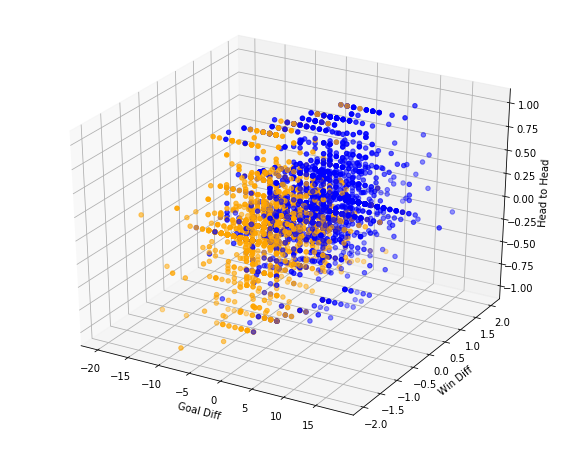

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

colors = np.where(data[:,3], "blue", "orange")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection="3d")
ax.scatter(data[:,0], data[:,1], data[:,2], c=colors)
ax.set_xlabel('Goal Diff')
ax.set_ylabel('Win Diff')
ax.set_zlabel('Head to Head')

I use a 2D histogram here to display the density of the data.

I used Win and Goal differential and not head-to-head as not all matches have a head-to-head.

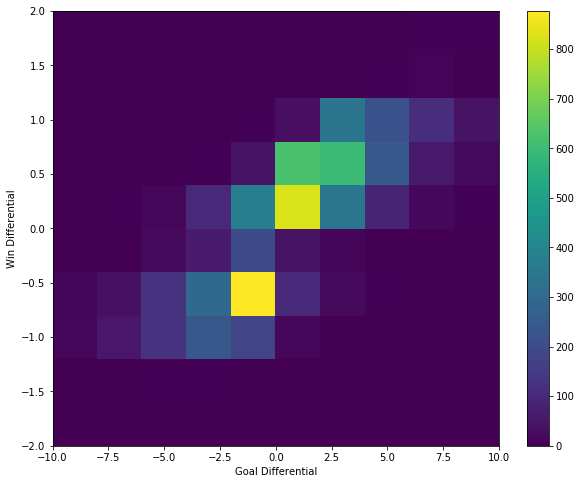

In [8]:
fig = plt.figure(figsize=(10,8))
plt.hist2d(x=data[:,0], y=data[:,1], range=[[-10, 10], [-2.0, 2.0]])
plt.colorbar()
plt.xlabel("Goal Differential")
plt.ylabel("Win Differential")
plt.show()

## Let's learn!

We'll use sklearn's method to split our train and testing data for us.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data[:,:3], data[:,3], test_size=0.35, shuffle=False
)

In [10]:
len(X_train), len(X_test)

(4321, 2328)

### Random Forest

We'll use the RandomForestClassifier by sklearn to try and learn from the past.

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=5, random_state=0)

In [15]:
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.7564432989690721

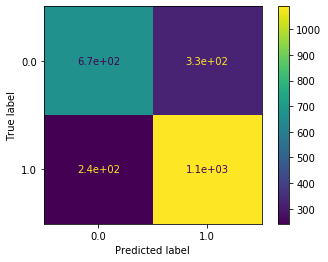

In [16]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf_rf, X_test, y_test)

Overall, not too bad! Let's see it in action!

## Let's do some predicting!

In [17]:
# A helper function for predicting and displaying results

def predictAndPrint(goal_diff, win_diff, head2head, clf):
    blue_prob = clf.predict_proba([[goal_diff, win_diff, head2head]])[0][1]
    print("Goal Difference: ", goal_diff);
    print("Win Difference: ", win_diff);
    print("Blue probability of winning: ", blue_prob)
    print("Orange probability of winning: ",  1 - blue_prob)

### EUnited versus Charlotte Phoenix

![EUnited vs. Charlotte Phoenix](../Images/EU_vs_CLT.png)

As you can see, a very close series. Let's see if we can predict the winner!

#### Game 1

In [20]:
goalDiff = 2 - 1 # E United wins 2 to 1
winDiff = (1 - 0) / 4 # Series is a best of 7 so first to 4 wins
head2head = 0 # Teams have never faced off before

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  1
Win Difference:  0.25
Blue probability of winning:  0.7811661978806704
Orange probability of winning:  0.21883380211932957


#### Game 2

In [21]:
goalDiff += (3 - 1) # E United wins again 3 to 1
winDiff = (2 - 0) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  3
Win Difference:  0.5
Blue probability of winning:  0.7946987931186493
Orange probability of winning:  0.20530120688135067


#### Game 3

In [22]:
goalDiff += (2 - 3) # Charlotte wins their first game 3 to 2
winDiff = (2 - 1) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  2
Win Difference:  0.25
Blue probability of winning:  0.8049815008160863
Orange probability of winning:  0.19501849918391367


Charlotte wins their first game, but it isn't by much giving EUnited still a strong advantage.

#### Game 4

In [23]:
goalDiff += (2 - 3) # Charlotte wins again 2 to 0 to tie the series
winDiff = (2 - 2) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  1
Win Difference:  0.0
Blue probability of winning:  0.5983171416348813
Orange probability of winning:  0.40168285836511874


Tying the series and shutting out EUnited has really boosted Charlotte's chances. EUnited down to 60% probability of winning.

#### Game 5

In [24]:
goalDiff += (0 - 1) # Charlotte wins game 5 with a score of 1 to 0
winDiff = (2 - 3) / 4#### Game 1

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  0
Win Difference:  -0.25
Blue probability of winning:  0.48890697816150863
Orange probability of winning:  0.5110930218384914


#### Game 6

In [25]:
goalDiff += (1 - 0) # EUnited stays alive with a score of 1 to 0
winDiff = (3 - 3) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  1
Win Difference:  0.0
Blue probability of winning:  0.5983171416348813
Orange probability of winning:  0.40168285836511874


EUnited tie up the series and take the advantage in probability to win due to their +1 goal difference.

EUnited goes on to win game 7 along with the series by a score of 2 to 1.

### The unpredictability of Rocket League

This series is an example of one of the most rare occurences in professional Rocket League. A best of 7 reverse sweep.

Dignitas, coming in as the underdog when looking at previous head to head matchups between these two teams, loses the first three games; and the matches are not even close.

Dignitas would go on to win the next 4 matches to win the series, blowing the mind of our model. Sometimes, there is just no predicting that.

![Dignitas vs. FC Barcelona](../Images/Dig_vs_FCB.png)

#### Game 1

In [26]:
goalDiff = 2 - 3 # Barcelona win 3 to 2
winDiff = (0 - 1) / 4 # Series is a best of 7 so first to 4 wins
head2head = ((3 + 2 + 1) - (1 + 3 + 3)) / (1 + 3 + 3 + 3 + 2 + 1)

print("Head to head: ", head2head)
predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Head to head:  -0.07692307692307693
Goal Difference:  -1
Win Difference:  -0.25
Blue probability of winning:  0.4136785939612125
Orange probability of winning:  0.5863214060387876


#### Game 2

In [27]:
goalDiff += (0 - 1) # Barcelona win 3 to 2
winDiff = (0 - 2) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  -2
Win Difference:  -0.5
Blue probability of winning:  0.3518521204008547
Orange probability of winning:  0.6481478795991453


#### Game 3

In [28]:
goalDiff += (1 - 5) # Barcelona win 3 to 2
winDiff = (0 - 3) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  -6
Win Difference:  -0.75
Blue probability of winning:  0.14461740152640654
Orange probability of winning:  0.8553825984735934


Best of 7 reverse sweeps are unheard of!

#### Game 4

In [29]:
goalDiff += (2 - 1) # Dignitas win their first game
winDiff = (1 - 3) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  -5
Win Difference:  -0.5
Blue probability of winning:  0.2680944944170623
Orange probability of winning:  0.7319055055829378


#### Game 5

In [30]:
goalDiff += (2 - 1) # Dignitas win their second game with a similar score
winDiff = (2 - 3) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  -4
Win Difference:  -0.25
Blue probability of winning:  0.36100137033299823
Orange probability of winning:  0.6389986296670018


#### Game 6

In [31]:
goalDiff += (3 - 2) # Dignitas win again to tie the series
winDiff = (3 - 3) / 4

predictAndPrint(goalDiff, winDiff, head2head, clf_rf)

Goal Difference:  -3
Win Difference:  0.0
Blue probability of winning:  0.49013244361850394
Orange probability of winning:  0.5098675563814961


Dignitas would go on to win the series. Absolutely destroying the win prbabilities predicted by the model.

Rocket League can be quite unpredictable at times. As one pro Rocket League player has said:

```
 Any team can beat any other team on any given day. 
 - Rizzo
```